In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

from sklearn.linear_model import LinearRegression, SGDRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## .......................................................................................................................

## Load data

In [4]:
# sample data
sample = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv')

In [5]:
sample.head()

,ID,total_amount
0,1,24.456348
1,2,24.374058
2,3,19.878154
3,4,25.015569
4,5,22.252489


In [6]:
# train data
data = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')

In [7]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [8]:
# test data
test_data = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv')

In [9]:
test_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee
0,1,2023-06-29 00:21:20,2023-06-29 00:25:20,1.0,4.95,1.0,N,20,3,Credit Card,1.0,6.067612,0.0,1.0,2.5,0.0
1,1,2023-06-30 17:44:43,2023-06-30 17:53:13,1.0,2.10,1.0,N,9,81,Credit Card,2.5,6.191269,0.0,1.0,2.5,0.0
2,1,2023-06-29 18:17:04,2023-06-29 19:23:48,1.0,0.95,1.0,N,92,90,Cash,2.5,3.983872,0.0,1.0,2.5,0.0
3,0,2023-06-30 21:33:53,2023-06-30 21:46:20,1.0,0.80,1.0,N,19,102,Credit Card,3.5,6.839341,0.0,1.0,2.5,0.0
4,1,2023-06-29 14:53:54,2023-06-29 15:22:17,1.0,4.01,1.0,N,131,229,Cash,0.0,1.468943,0.0,1.0,0.0,0.0


## .......................................................................................................................

### EDA:

### Data shape

In [10]:
data.shape

(175000, 17)

* 175000 samples
* 17 columns including target variable - total_amount

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID           175000 non-null  int64  
 8   DOLocationID           175000 non-null  int64  
 9   payment_type           175000 non-null  object 
 10  extra                  175000 non-null  float64
 11  tip_amount             175000 non-null  float64
 12  tolls_amount           175000 non-null  float64
 13  improvement_surcharge  175000 non-null  float64
 14  total_amount           175000 non-nu

In [12]:
print(data.select_dtypes(include=['object']).columns) # object type
print('.............')
print(data.select_dtypes(include=['int', 'float']).columns) # numerical 

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag',
       'payment_type'],
      dtype='object')
.............
Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'extra', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'Airport_fee'],
      dtype='object')


#### Observations:
* **Numerical features**: 
        'VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'extra', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'congestion_surcharge', 'Airport_fee'
       
* **Categorical features**: 
    'store_and_fwd_flag', 'payment_type'
* **Datetime**: 
    'tpep_pickup_datetime', 'tpep_dropoff_datetime' are variables of 'object' data type, which are to be converted to 'datetime' type.

## .......................................................................................................................

#### Descriptive statistics:

In [13]:
data.describe(include='all')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,175000.000000,175000,175000,168923.000000,175000.000000,168923.000000,168923,175000.000000,175000.000000,175000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,168923.000000,168923.000000
unique,NaN,109877,109713,NaN,NaN,NaN,2,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2023-06-28 18:11:16,2023-06-29 19:08:22,NaN,NaN,NaN,N,NaN,NaN,Credit Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,8,10,NaN,NaN,NaN,167729,NaN,NaN,135257,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.728377,NaN,NaN,1.357678,5.145930,1.518307,NaN,132.710349,132.701429,NaN,1.932143,6.127497,0.646816,0.979689,29.633901,2.246971,0.158825
std,0.445606,NaN,NaN,0.891283,394.971052,6.514678,NaN,76.148799,76.192493,NaN,1.948497,4.610834,2.328274,0.198775,25.425206,0.819216,0.511968
min,0.000000,NaN,NaN,0.000000,0.000000,1.000000,NaN,1.000000,1.000000,NaN,-7.500000,0.000079,-29.300000,-1.000000,-576.750000,-2.500000,-1.750000
25%,0.000000,NaN,NaN,1.000000,1.080000,1.000000,NaN,67.000000,67.000000,NaN,0.000000,3.473321,0.000000,1.000000,16.300000,2.500000,0.000000
50%,1.000000,NaN,NaN,1.000000,1.840000,1.000000,NaN,133.000000,133.000000,NaN,1.000000,5.286217,0.000000,1.000000,21.450000,2.500000,0.000000
75%,1.000000,NaN,NaN,1.000000,3.610000,1.000000,NaN,199.000000,199.000000,NaN,2.500000,7.502746,0.000000,1.000000,31.800000,2.500000,0.000000


## .......................................................................................................................

#### Data vizualization:
**1. Histogram:**

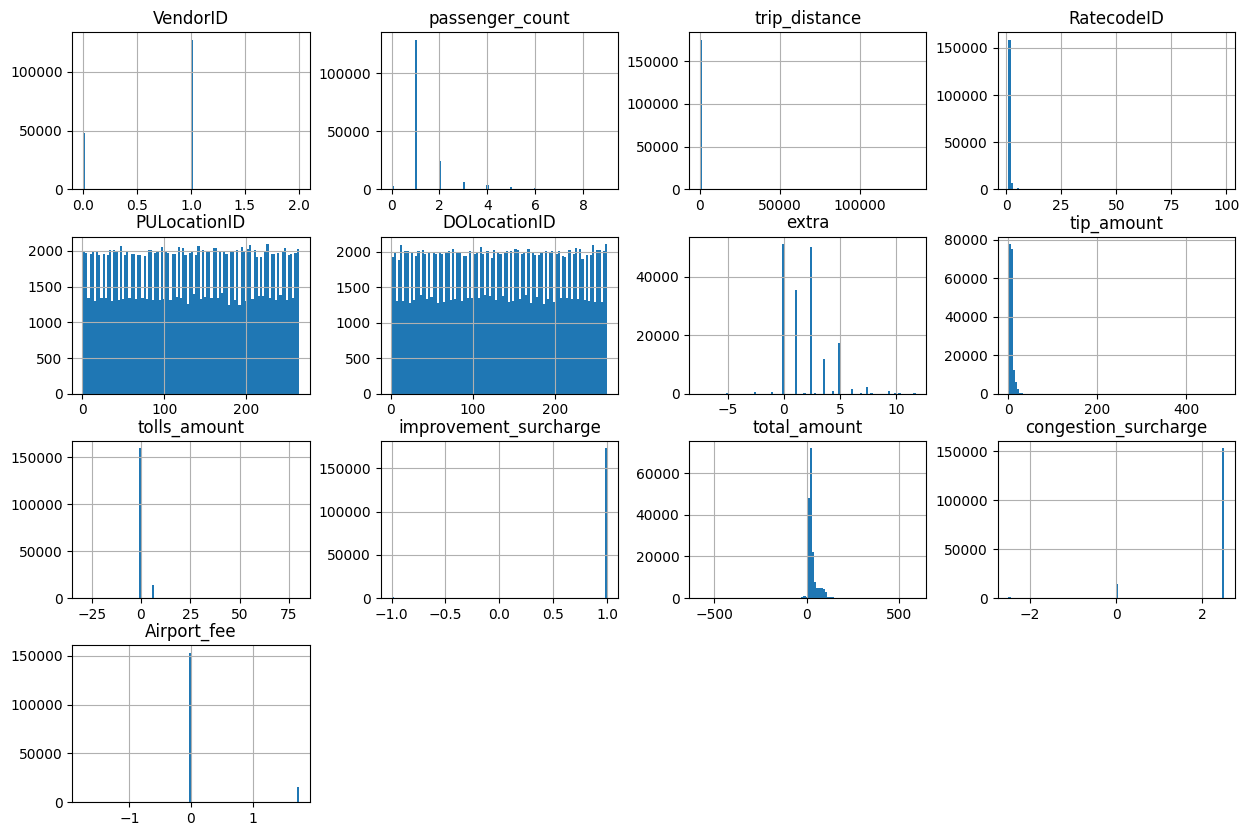

In [14]:
# Plot histogram
data.hist(bins = 100, figsize=(15,10))
plt.show()

In [15]:
# counts of unique values
lst = data.select_dtypes(['int', 'float'])
for i, v in lst.items():
    print(i)
    print(data[i].value_counts())
    print("..............................")

VendorID
VendorID
1    127340
0     47597
2        63
Name: count, dtype: int64
..............................
passenger_count
passenger_count
1.0    128534
2.0     24316
3.0      6018
4.0      3668
0.0      2818
5.0      1970
6.0      1596
8.0         2
9.0         1
Name: count, dtype: int64
..............................
trip_distance
trip_distance
0.00     2632
1.00     2431
0.90     2383
1.20     2363
1.10     2297
         ... 
31.42       1
26.80       1
27.53       1
13.29       1
15.17       1
Name: count, Length: 2929, dtype: int64
..............................
RatecodeID
RatecodeID
1.0     158652
2.0       7314
5.0       1036
99.0       748
3.0        727
4.0        446
Name: count, dtype: int64
..............................
PULocationID
PULocationID
264    730
85     725
43     719
162    718
97     717
      ... 
254    613
94     613
153    611
179    606
252    606
Name: count, Length: 264, dtype: int64
..............................
DOLocationID
DOLocationID
263    75

**Observations:** 
* **RatecodeID, passenger_count, tolls_amount, VendorID, Airport_fee, congestion_surcharge and improvement_surcharge** have a unique mode or one single peak. Thus they are unimodal.

* **extra, trip_distance, tip_amount, total_amount** have got multiple peaks. Thus, they are multimodal.

* **VendorID** has three distinct groups i.e '0', '1' and '2' within the data set, with most of the entries having 'VendorID' = 1.

* **Airport_fee** has three distinct groups i.e '-1.75', '0' and '1.75' within the data set, with most of the entries having 'Airport_fee' = 0.

* **congestion_surcharge** has three distinct groups i.e '-2.5', '0' and '2.5' within the data set, with most of the entries having 'congestion_surcharge' = 2.5.

* **PULocationID** and **DOLocationID**: the frequencies of all bins are roughly the same. Thus, the distribution is uniform.



**2. Catplot:** (for categorical features)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


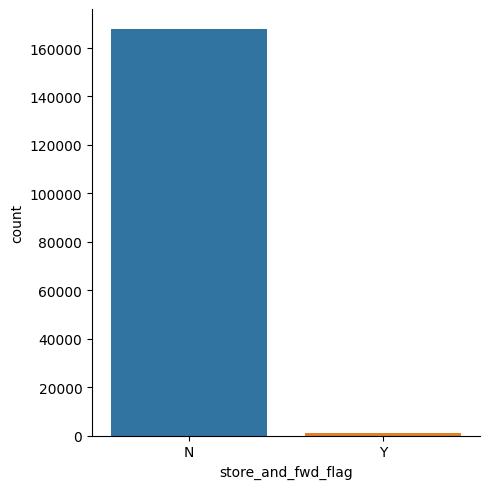

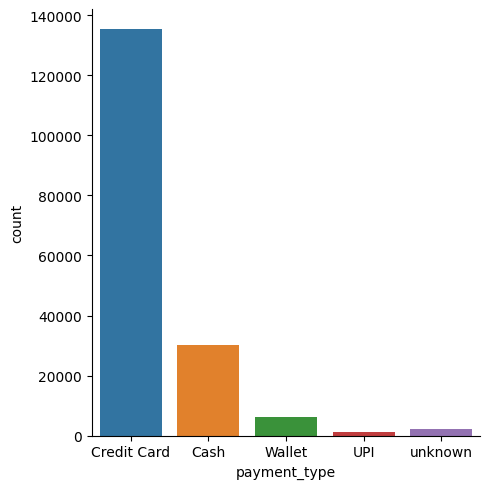

In [16]:
# plot catplot
sns.catplot(data=data, x='store_and_fwd_flag', kind='count')
sns.catplot(data=data, x='payment_type', kind='count')

In [17]:
# counts of unique values
print(data['store_and_fwd_flag'].value_counts())
print(data['payment_type'].value_counts())

store_and_fwd_flag
N    167729
Y      1194
Name: count, dtype: int64
payment_type
Credit Card    135257
Cash            30141
Wallet           6077
unknown          2333
UPI              1192
Name: count, dtype: int64


**Observations:**
* **'store_and_fwd_flag':** 
    * Has two distinct groups i.e 'N' and 'Y' within the data set.
    * Most frequent value is 'N'.
* **'payment_type':** 
    * Has four distinct groups within the data set.
    * Most frequent value is 'Credit Card'.

**3. Boxplot:**

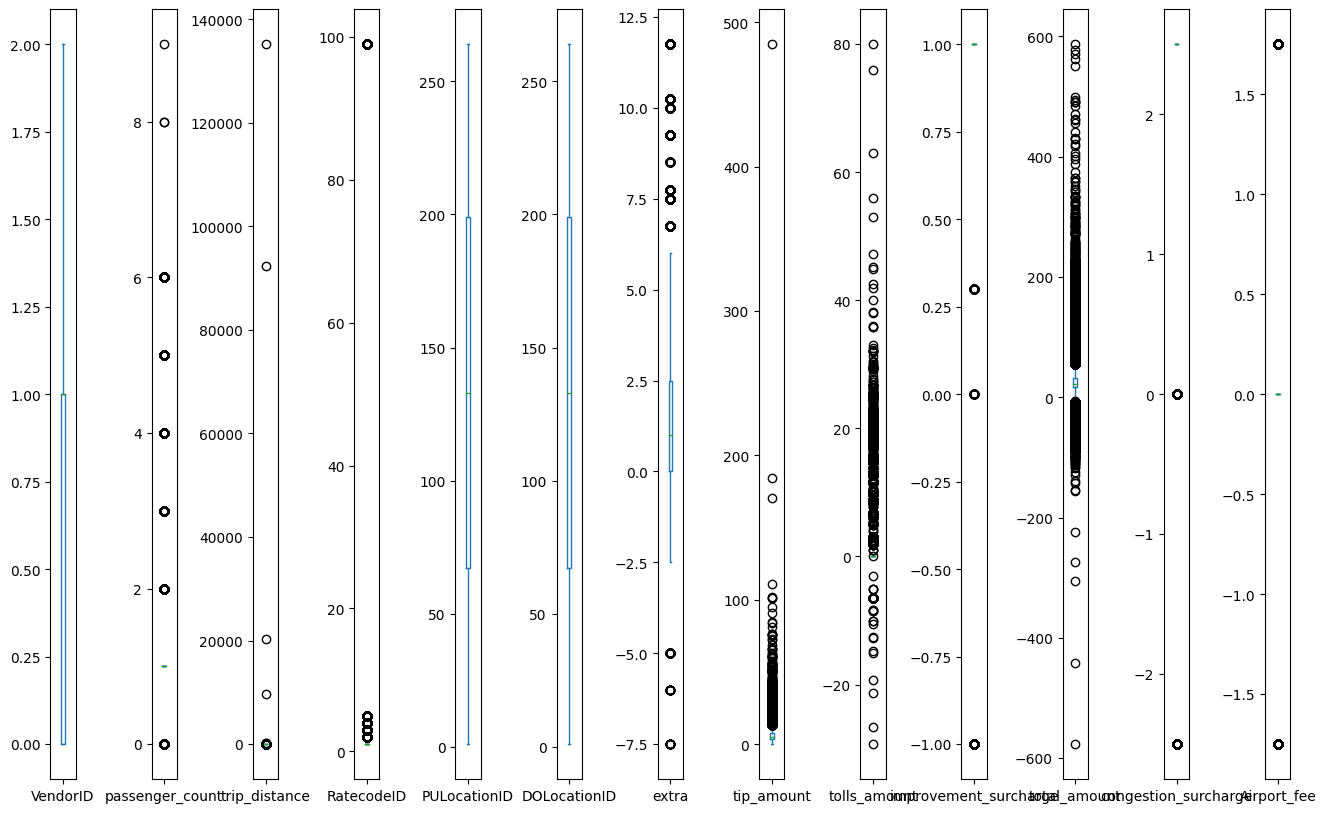

In [18]:
# plot boxplot
data.plot(kind='box',sharey = False, subplots=True,figsize=(16,10))
plt.subplots_adjust(wspace = 3)
plt.show()

In [19]:
# trip_distance
print(data[(data['trip_distance'] > 9000) | (data['trip_distance'] == 0)].shape)

# tip_amout
print(data[data['tip_amount'] > 400].shape)

# Average fare
print(data['total_amount'].mean())

# passenger_count
print(data[data['passenger_count'] == 0].shape)

(2636, 17)
(1, 17)
29.633900971428567
(2818, 17)


#### Observations:

* **trip_distance:** 
    * trip_distance > 9000 is very large (4 entries)
    * trip_distance == 0 is not possible (2632 entries)
    * Replace those values with the median.
    
* **tip_amout:** 
    * Average fare = 29.63
    * tip > 400 is very high compared to average fare. (1 entry)
    * It is replaced with the median.
    
* **passenger_count:**
    * 0 passengers is not possible. (2818 entries)
    * Replace values equal to 0 with the median.

## .......................................................................................................................

#### Correlation Matrix:
* Find highly correlated features and remove the columns.  
* The columns that have correlation values of more than 0. 75 will be removed.

In [20]:
corr = data.corr(method='pearson', numeric_only=True)
corr

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
VendorID,1.000000,0.099990,0.002857,-0.106361,-0.001315,-0.003946,-0.530096,0.043941,0.023642,-0.063197,0.039695,-0.023495,0.036483
passenger_count,0.099990,1.000000,0.010163,-0.023627,-0.000822,-0.000726,-0.039732,0.017175,0.042856,-0.002800,0.053224,-0.002266,0.040786
trip_distance,0.002857,0.010163,1.000000,0.014745,-0.000958,-0.002496,-0.001849,0.005847,0.006778,0.000459,0.009911,-0.060883,0.126236
RatecodeID,-0.106361,-0.023627,0.014745,1.000000,-0.001090,-0.000644,-0.070959,-0.032172,0.063754,0.002579,0.055527,-0.197608,-0.004480
PULocationID,-0.001315,-0.000822,-0.000958,-0.001090,1.000000,-0.000161,0.001495,0.000748,-0.000868,-0.000501,0.000715,0.001194,-0.000654
DOLocationID,-0.003946,-0.000726,-0.002496,-0.000644,-0.000161,1.000000,0.002955,-0.000247,-0.002290,-0.002810,-0.002954,0.000641,-0.004940
extra,-0.530096,-0.039732,-0.001849,-0.070959,0.001495,0.002955,1.000000,0.160331,0.201179,0.170831,0.234346,0.068088,0.337456
tip_amount,0.043941,0.017175,0.005847,-0.032172,0.000748,-0.000247,0.160331,1.000000,0.411588,0.076436,0.638658,-0.059346,0.335614
tolls_amount,0.023642,0.042856,0.006778,0.063754,-0.000868,-0.002290,0.201179,0.411588,1.000000,0.051190,0.684765,-0.134409,0.437600
improvement_surcharge,-0.063197,-0.002800,0.000459,0.002579,-0.000501,-0.002810,0.170831,0.076436,0.051190,1.000000,0.224036,0.528606,0.083739


In [21]:
cols_to_drop = []
for i in corr:
    for j, v in corr[i].items():
        if ((j != i) and ((i != 'total_amount') or (j != 'total_amount')) and (abs(v) >= 0.75)):
            cols_to_drop.append(j)
            # data = data.drop([j], axis=1)
    
print(cols_to_drop)

# No columns to drop

[]


## .......................................................................................................................

#### 'tpep_pickup_datetime' and 'tpep_dropoff_datetime' columns:
* Split into year, month, day, hour, minute and second columns.
* Delete the year column as it has just 1 unique value.
* Merge the hour, minute and second column into one column by converting hours and seconds into minutes and then adding the three together.
* Name the new columns 'tpep_pickup_time' and 'tpep_dropoff_time'.
* Drop originial date-time columns and hour, minute and seconds column.

In [22]:
# Convert to datetime
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [23]:
# Convert to datetime
test_data['tpep_pickup_datetime'] = pd.to_datetime(test_data['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test_data['tpep_dropoff_datetime'] = pd.to_datetime(test_data['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [24]:
# Split into year, month, day, hour, minute and second columns
data['tpep_pickup_year'] = data['tpep_pickup_datetime'].dt.year
data['tpep_dropoff_year'] = data['tpep_dropoff_datetime'].dt.year

data['tpep_pickup_month'] = data['tpep_pickup_datetime'].dt.month
data['tpep_dropoff_month'] = data['tpep_dropoff_datetime'].dt.month

data['tpep_pickup_day'] = data['tpep_pickup_datetime'].dt.day
data['tpep_dropoff_day'] = data['tpep_dropoff_datetime'].dt.day

data['tpep_pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['tpep_dropoff_hour'] = data['tpep_dropoff_datetime'].dt.hour

data['tpep_pickup_min'] = data['tpep_pickup_datetime'].dt.minute
data['tpep_dropoff_min'] = data['tpep_dropoff_datetime'].dt.minute

data['tpep_pickup_sec'] = data['tpep_pickup_datetime'].dt.second
data['tpep_dropoff_sec'] = data['tpep_dropoff_datetime'].dt.second

In [25]:
# Split into year, month, day, hour, minute and second columns
test_data['tpep_pickup_year'] = test_data['tpep_pickup_datetime'].dt.year
test_data['tpep_dropoff_year'] = test_data['tpep_dropoff_datetime'].dt.year

test_data['tpep_pickup_month'] = test_data['tpep_pickup_datetime'].dt.month
test_data['tpep_dropoff_month'] = test_data['tpep_dropoff_datetime'].dt.month

test_data['tpep_pickup_day'] = test_data['tpep_pickup_datetime'].dt.day
test_data['tpep_dropoff_day'] = test_data['tpep_dropoff_datetime'].dt.day

test_data['tpep_pickup_hour'] = test_data['tpep_pickup_datetime'].dt.hour
test_data['tpep_dropoff_hour'] = test_data['tpep_dropoff_datetime'].dt.hour

test_data['tpep_pickup_min'] = test_data['tpep_pickup_datetime'].dt.minute
test_data['tpep_dropoff_min'] = test_data['tpep_dropoff_datetime'].dt.minute

test_data['tpep_pickup_sec'] = test_data['tpep_pickup_datetime'].dt.second
test_data['tpep_dropoff_sec'] = test_data['tpep_dropoff_datetime'].dt.second

In [26]:
# Counts of values in the year column
print(data['tpep_pickup_year'].value_counts())
print(data['tpep_dropoff_year'].value_counts())
# Only a single unique value present.

tpep_pickup_year
2023    175000
Name: count, dtype: int64
tpep_dropoff_year
2023    175000
Name: count, dtype: int64


In [27]:
# Merge the hour, minute and second column into one column by converting hours and seconds into minutes
# add the three together.
# Name the new columns 'tpep_pickup_time' and 'tpep_dropoff_time'.
for i in data.index:
    data['tpep_pickup_time'] = (data.loc[i, 'tpep_pickup_hour']*60) + (data.loc[i, 'tpep_pickup_min']) + (data.loc[i, 'tpep_pickup_sec']/60)
    data['tpep_dropoff_time'] = (data.loc[i, 'tpep_dropoff_hour']*60) + (data.loc[i, 'tpep_dropoff_min']) + (data.loc[i, 'tpep_dropoff_sec']/60)

In [28]:
# Merge the hour, minute and second column into one column by converting hours and seconds into minutes
# Add the three together.
# Name the new columns 'tpep_pickup_time' and 'tpep_dropoff_time'.
for i in test_data.index:
    test_data['tpep_pickup_time'] = (test_data.loc[i, 'tpep_pickup_hour']*60) + (test_data.loc[i, 'tpep_pickup_min']) + (test_data.loc[i, 'tpep_pickup_sec']/60)
    test_data['tpep_dropoff_time'] = (test_data.loc[i, 'tpep_dropoff_hour']*60) + (test_data.loc[i, 'tpep_dropoff_min']) + (test_data.loc[i, 'tpep_dropoff_sec']/60)

In [29]:
# drop originial date-time columns
# drop year column as single value
# drop hour, minute and seconds column.
data = data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'tpep_pickup_year', 'tpep_dropoff_year', 'tpep_pickup_hour', 'tpep_dropoff_hour', 'tpep_pickup_min', 'tpep_dropoff_min', 'tpep_pickup_sec', 'tpep_dropoff_sec'], axis=1)
data.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'extra', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'tpep_pickup_month', 'tpep_dropoff_month', 'tpep_pickup_day',
       'tpep_dropoff_day', 'tpep_pickup_time', 'tpep_dropoff_time'],
      dtype='object')

In [30]:
# drop originial date-time columns
# drop year column as single value
# drop hour, minute and seconds column.
test_data = test_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'tpep_pickup_year', 'tpep_dropoff_year', 'tpep_pickup_hour', 'tpep_dropoff_hour', 'tpep_pickup_min', 'tpep_dropoff_min', 'tpep_pickup_sec', 'tpep_dropoff_sec'], axis=1)
test_data.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'extra', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'congestion_surcharge', 'Airport_fee', 'tpep_pickup_month',
       'tpep_dropoff_month', 'tpep_pickup_day', 'tpep_dropoff_day',
       'tpep_pickup_time', 'tpep_dropoff_time'],
      dtype='object')

## .......................................................................................................................

#### Train-test-split

In [31]:
X = data.drop(['total_amount'], axis=1)
y = data['total_amount']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((140000, 20), (35000, 20), (140000,), (35000,))

## .......................................................................................................................

### Preprocessing

#### Handling outliers:

* **trip_distance:** 
    * trip_distance > 9000 is very large
    * trip_distance == 0 is not possible 
    * Replace those values with the median.
    

In [33]:
#X_train
ind = X_train[(X_train['trip_distance'] >= 9000) | (X_train['trip_distance'] == 0)].index
x = X_train['trip_distance'].median()
for i in ind:
    out = X_train.loc[i, 'trip_distance']
    X_train['trip_distance'] = X_train['trip_distance'].replace(out, x)

print(X_train['trip_distance'].mean()) # 3.7

3.707778642857143


In [34]:
#X_test
ind = X_test[(X_test['trip_distance'] >= 9000) | (X_test['trip_distance'] == 0)].index
x = X_test['trip_distance'].median()
for i in ind:
    out = X_test.loc[i, 'trip_distance']
    X_test['trip_distance'] = X_test['trip_distance'].replace(out, x)

print(X_test['trip_distance'].mean())

3.6806099999999997


In [35]:
#test_data
ind = test_data[(test_data['trip_distance'] >= 9000) | (test_data['trip_distance'] == 0)].index
x = test_data['trip_distance'].median()
for i in ind:
    out = test_data.loc[i, 'trip_distance']
    test_data['trip_distance'] = test_data['trip_distance'].replace(out, x)

print(test_data['trip_distance'].mean())

3.6740156000000006


* **tip_amout:** 
    * tip > 400 is very high compared to average fare.
    * It is replaced with the median.

In [36]:
#X_train
lst = X_train[X_train['tip_amount'] > 400]['tip_amount'].index

for i in lst:
    res = X_train.loc[i, 'tip_amount']
    print('before: ', res)
    print('......')
    X_train['tip_amount'] = X_train['tip_amount'].replace(res, X_train['tip_amount'].median())
    out = X_train.loc[i, 'tip_amount']
    print('after: ', out)
    print('......')
    

before:  484.876150598094
......
after:  5.288746925220948
......


In [37]:
#X_test
lst = X_test[X_test['tip_amount'] > 400]['tip_amount'].index

for i in lst:
    res = X_test.loc[i, 'tip_amount']
    print('before: ', res)
    print('......')
    X_test['tip_amount'] = X_test['tip_amount'].replace(res, X_train['tip_amount'].median())
    out = X_test.loc[i, 'tip_amount']
    print('after: ', out)
    print('......')

In [38]:
#test_data
lst = test_data[test_data['tip_amount'] > 400]['tip_amount'].index

for i in lst:
    res = test_data.loc[i, 'tip_amount']
    print('before: ', res)
    print('......')
    test_data['tip_amount'] = test_data['tip_amount'].replace(res, X_train['tip_amount'].median())
    out = test_data.loc[i, 'tip_amount']
    print('after: ', out)
    print('......')

* **passenger_count:**
    * 0 passengers is not possible.
    * Replace values equal to 0 with the median.

In [39]:
#X_train
lst = X_train[X_train['passenger_count'] == 0]['passenger_count'].index

for i in lst:
    res = X_train.loc[i, 'passenger_count']
    X_train['passenger_count'] = X_train['passenger_count'].replace(res, X_train['passenger_count'].median())
    out = X_train.loc[i, 'passenger_count']
    

In [40]:
#X_test
lst = X_test[X_test['passenger_count'] == 0]['passenger_count'].index

for i in lst:
    res = X_test.loc[i, 'passenger_count']
    X_test['passenger_count'] = X_test['passenger_count'].replace(res, X_train['passenger_count'].median())
    out = X_test.loc[i, 'passenger_count']

In [41]:
#test_data
lst = test_data[test_data['passenger_count'] == 0]['passenger_count'].index

for i in lst:
    res = test_data.loc[i, 'passenger_count']
    test_data['passenger_count'] = test_data['passenger_count'].replace(res, X_train['passenger_count'].median())
    out = test_data.loc[i, 'passenger_count']

## .......................................................................................................................

#### Null values:
Following features contain null values.
* **categorical**: 'store_and_fwd_flag'
* **numerical**: 'passenger_count', 'RatecodeID', 'congestion_surcharge', 'Airport_fee'

In [42]:
print(data.isnull().sum())
print('.......')
print(data.isin(['?']).sum())

VendorID                    0
passenger_count          6077
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
tpep_pickup_month           0
tpep_dropoff_month          0
tpep_pickup_day             0
tpep_dropoff_day            0
tpep_pickup_time            0
tpep_dropoff_time           0
dtype: int64
.......
VendorID                 0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
extra                    0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             

## .......................................................................................................................

#### Imputation: Simple Imputer
* **categorical:** strategy - most frequent
* **numerical:** strategy - mean

In [43]:
si_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
si_num = SimpleImputer(missing_values=np.nan, strategy='mean')

In [44]:
trf1 = [('si_cat', si_cat, ['store_and_fwd_flag']),
        ('si_num', si_num, ['passenger_count', 'RatecodeID', 'congestion_surcharge', 'Airport_fee'])]

In [45]:
ct1 = ColumnTransformer(transformers=trf1, remainder='passthrough', verbose_feature_names_out = False).set_output(transform='pandas')
ct1

ColumnTransformer(remainder='passthrough',
                  transformers=[('si_cat',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['store_and_fwd_flag']),
                                ('si_num', SimpleImputer(),
                                 ['passenger_count', 'RatecodeID',
                                  'congestion_surcharge', 'Airport_fee'])],
                  verbose_feature_names_out=False)

In [46]:
ct1.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('si_cat',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['store_and_fwd_flag']),
                                ('si_num', SimpleImputer(),
                                 ['passenger_count', 'RatecodeID',
                                  'congestion_surcharge', 'Airport_fee'])],
                  verbose_feature_names_out=False)

In [47]:
X_train = ct1.transform(X_train)
X_test = ct1.transform(X_test)
test_data = ct1.transform(test_data)

In [48]:
X_train.head()

,store_and_fwd_flag,passenger_count,RatecodeID,congestion_surcharge,Airport_fee,VendorID,trip_distance,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,tpep_pickup_month,tpep_dropoff_month,tpep_pickup_day,tpep_dropoff_day,tpep_pickup_time,tpep_dropoff_time
143961,N,1.0,1.0,0.0,1.75,1,7.79,181,174,Credit Card,1.0,7.956385,0.0,1.0,6,6,29,30,1286.716667,1374.7
170292,N,1.0,1.0,2.5,0.00,1,0.79,250,226,Credit Card,2.5,2.276785,0.0,1.0,6,6,28,28,1286.716667,1374.7
161029,N,1.0,2.0,-2.5,0.00,1,0.29,236,251,unknown,0.0,1.062698,0.0,-1.0,6,6,30,30,1286.716667,1374.7
84006,N,1.0,1.0,2.5,0.00,0,0.60,83,166,Credit Card,3.5,2.444217,0.0,1.0,6,6,29,29,1286.716667,1374.7
95628,N,1.0,1.0,2.5,0.00,0,1.90,70,35,Credit Card,5.0,5.163920,0.0,1.0,6,6,28,28,1286.716667,1374.7


## .......................................................................................................................

#### Duplicate rows:
* No duplicates present.

In [49]:
data.duplicated().sum()

0

## .......................................................................................................................

#### Encoding and scaling:
* Encode categorical features.
    * Ordinal: OrdinalEncoder
    * Nominal: OneHotEncoder
* Scale numerical features using MinMaxScaler.

In [50]:
categorical = X_train.select_dtypes(include=['object']).columns
numerical = X_train.select_dtypes(include=['int', 'float']).columns
print(categorical)
print('..........')
print(numerical)

Index(['store_and_fwd_flag', 'payment_type'], dtype='object')
..........
Index(['passenger_count', 'RatecodeID', 'congestion_surcharge', 'Airport_fee',
       'VendorID', 'trip_distance', 'PULocationID', 'DOLocationID', 'extra',
       'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'tpep_pickup_month', 'tpep_dropoff_month', 'tpep_pickup_day',
       'tpep_dropoff_day', 'tpep_pickup_time', 'tpep_dropoff_time'],
      dtype='object')


In [51]:
ohe = OneHotEncoder(sparse_output=False)
mms = MinMaxScaler()

In [52]:
trf2 = [('ohe', ohe, categorical), ('mms', mms, numerical)]

In [53]:
ct2 = ColumnTransformer(transformers=trf2, remainder='passthrough', verbose_feature_names_out = False).set_output(transform='pandas')
ct2

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(sparse_output=False),
                                 Index(['store_and_fwd_flag', 'payment_type'], dtype='object')),
                                ('mms', MinMaxScaler(),
                                 Index(['passenger_count', 'RatecodeID', 'congestion_surcharge', 'Airport_fee',
       'VendorID', 'trip_distance', 'PULocationID', 'DOLocationID', 'extra',
       'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'tpep_pickup_month', 'tpep_dropoff_month', 'tpep_pickup_day',
       'tpep_dropoff_day', 'tpep_pickup_time', 'tpep_dropoff_time'],
      dtype='object'))],
                  verbose_feature_names_out=False)

## .......................................................................................................................

#### Feature Selection:

#### PCA:

In [54]:
pca = PCA(n_components=8) # score for SGDRegressor: 0.81

#### SelectKBest:

In [55]:
skb = SelectKBest(f_regression, k=18) 
# score for SGDRegressor
#18: 0.8795587839384801
#15: 0.8795559673233831
#20: 0.87954134572976
#12: 0.8786932739186317 
#10: 0.878632060096975 
#8: 0.8769226169772277

#### VarianceThreshold:

In [56]:
vt = VarianceThreshold()

## .......................................................................................................................

### MODEL-1
#### XGBRegressor with RandomizedSearchCV

In [57]:
xg = xgb.XGBRegressor(n_estimators = 600, max_depth = 5, learning_rate = 0.015, random_state = 42) # best parameters

- **Pipeline:**
    - ColumnTransformer: OneHotEncoder and MinMaxScaler
    - VarianceThreshold
    - XGBRegressor

In [58]:
stp1 = [('ct2', ct2), ('vt', vt), ('xg', xg)]

In [59]:
pipe1 = Pipeline(steps=stp1).set_output(transform='pandas')

In [60]:
pipe1.fit(X_train, y_train)

Pipeline(steps=[('ct2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  Index(['store_and_fwd_flag', 'payment_type'], dtype='object')),
                                                 ('mms', MinMaxScaler(),
                                                  Index(['passenger_count', 'RatecodeID', 'congestion_surcharge', 'Airport_fee',
       'VendorID', 'trip_distance', 'PULocationID', 'DOLocationID', 'extra',
       'tip_a...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.015,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=600,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [61]:
train_score1 = pipe1.score(X_train, y_train)
train_score1

0.9532548778787405

In [62]:
score1 = r2_score(y_test, pipe1.predict(X_test)) 
score1
# 0.9568975056524907 # 0.94484

0.9568975056524907

- **Hyperparameter tuning:**

In [63]:
'''param = {"xg__max_depth":    [4, 5, 6],
         "xg__n_estimators": [500, 600, 700],
         "xg__learning_rate": [0.01, 0.015]}'''

'param = {"xg__max_depth":    [4, 5, 6],\n         "xg__n_estimators": [500, 600, 700],\n         "xg__learning_rate": [0.01, 0.015]}'

In [64]:
'''random = RandomizedSearchCV(estimator = pipe, param_distributions = param,
                               cv = 2, n_iter = 10, n_jobs=-1)'''

'random = RandomizedSearchCV(estimator = pipe, param_distributions = param,\n                               cv = 2, n_iter = 10, n_jobs=-1)'

In [65]:
#random.fit(X_train, y_train)

In [66]:
#random.best_params_
# {'xg__n_estimators': 600, 'xg__max_depth': 5, 'xg__learning_rate': 0.015}

In [67]:
#r2_score(y_test, random.predict(X_test)) 
# with hpt # 0.9568975056524907 # 0.93519

## .......................................................................................................................

### MODEL-2
#### SGDRegressor with GridSearchCV

In [68]:
sgd = SGDRegressor(alpha = 1e-05, penalty = 'l1', tol = 0.0001, random_state = 42) # best parameters

- **Pipeline:**
    - ColumnTransformer: OneHotEncoder and MinMaxScaler
    - VarianceThreshold
    - SGDRegressor

In [69]:
stp2 = [('ct2', ct2), ('vt', vt), ('sgd', sgd)]

In [70]:
pipe2 = Pipeline(steps=stp2).set_output(transform='pandas')

In [71]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('ct2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  Index(['store_and_fwd_flag', 'payment_type'], dtype='object')),
                                                 ('mms', MinMaxScaler(),
                                                  Index(['passenger_count', 'RatecodeID', 'congestion_surcharge', 'Airport_fee',
       'VendorID', 'trip_distance', 'PULocationID', 'DOLocationID', 'extra',
       'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'tpep_pickup_month', 'tpep_dropoff_month', 'tpep_pickup_day',
       'tpep_dropoff_day', 'tpep_pickup_time', 'tpep_dropoff_time'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('vt', VarianceThreshold()),
                ('sgd',
                 SGDRegressor(alpha=1e-05, penalty='l1', random_state=42,
                              tol=0.0001))])

In [72]:
train_score2 = pipe2.score(X_train, y_train)
train_score2

0.8578073925312962

In [73]:
score2 = r2_score(y_test, pipe2.predict(X_test)) # 0.8789061024260565
score2

0.8789061024260565

- **Hyperparameter tuning:**

In [74]:
#params = {'sgd__penalty': ['l1', 'l2'], 'sgd__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],  'sgd__tol': [1e-4, 1e-3, 1e-2, 1e-1]}

In [75]:
#grid = GridSearchCV(estimator = pipe, param_grid = params, cv = 5, n_jobs = -1)

In [76]:
#grid.fit(X_train, y_train)

In [77]:
#grid.best_params_

In [78]:
#r2_score(y_test, grid.predict(X_test)) # 0.8789061024260565

## .......................................................................................................................

### MODEL-3
#### RandomForestRegressor

In [79]:
rfr = RandomForestRegressor(random_state=42)

- **Pipeline:**
    - ColumnTransformer: OneHotEncoder and MinMaxScaler
    - VarianceThreshold
    - RandomForestRegressor

In [80]:
stp3 = [('ct2', ct2), ('vt', vt), ('rfr', rfr)]

In [81]:
pipe3 = Pipeline(steps=stp3).set_output(transform='pandas')

In [82]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('ct2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  Index(['store_and_fwd_flag', 'payment_type'], dtype='object')),
                                                 ('mms', MinMaxScaler(),
                                                  Index(['passenger_count', 'RatecodeID', 'congestion_surcharge', 'Airport_fee',
       'VendorID', 'trip_distance', 'PULocationID', 'DOLocationID', 'extra',
       'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'tpep_pickup_month', 'tpep_dropoff_month', 'tpep_pickup_day',
       'tpep_dropoff_day', 'tpep_pickup_time', 'tpep_dropoff_time'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('vt', VarianceThreshold()),
                ('rfr', RandomForestRegressor(random_state=42))])

In [83]:
train_score3 = pipe3.score(X_train, y_train)
train_score3

0.9913846549937125

In [84]:
score3 = r2_score(y_test, pipe3.predict(X_test))
score3
# 0.9541987630104413 # 0.93744 

0.9541987630104413

## .......................................................................................................................

### Model Comparison:

In [85]:
# train data score
results = pd.DataFrame({'Model':['XGBRegressor','SGDRegressor','RandomForestRegressor'],
                    'R2 Score':[train_score1, train_score2, train_score3]})
result1 = results.sort_values(by='R2 Score', ascending=False)
result1 = result1.set_index('Model')
result1

,R2 Score
Model,
RandomForestRegressor,0.991385
XGBRegressor,0.953255
SGDRegressor,0.857807


<Axes: xlabel='Model'>

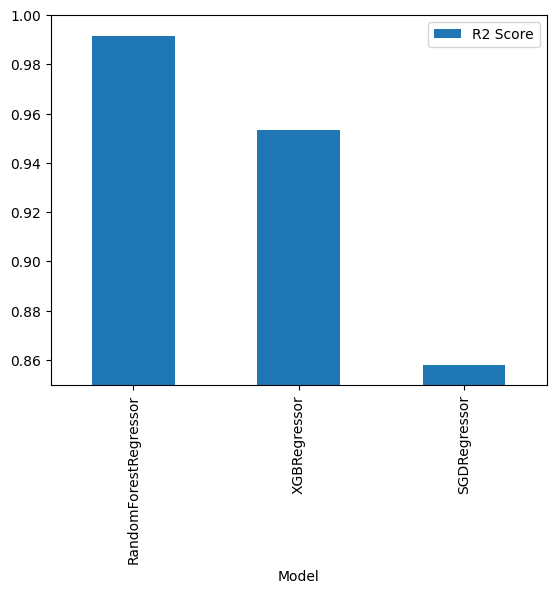

In [86]:
result1.plot.bar(ylim=(0.85, 1.0))

In [87]:
# test set score
results = pd.DataFrame({'Model':['XGBRegressor','SGDRegressor','RandomForestRegressor'],
                    'R2 Score':[score1, score2, score3]})
result2 = results.sort_values(by='R2 Score', ascending=False)
result2 = result2.set_index('Model')
result2

,R2 Score
Model,
XGBRegressor,0.956898
RandomForestRegressor,0.954199
SGDRegressor,0.878906


<Axes: xlabel='Model'>

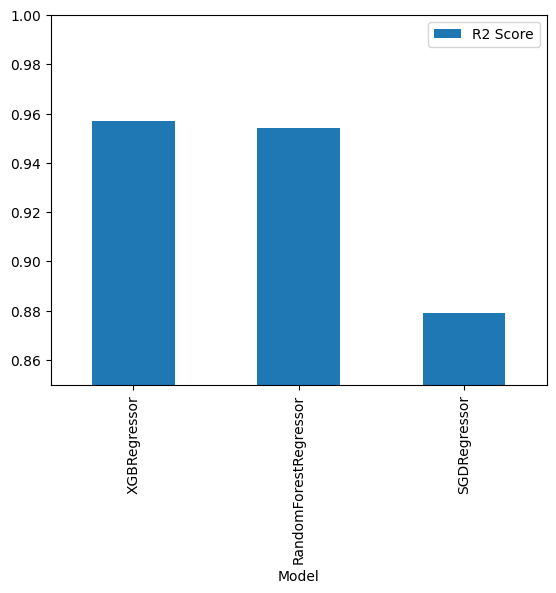

In [88]:
result2.plot.bar(ylim=(0.85, 1.0))

#### Conclusion: 
**Train set:**
* Highest score was achieved using RandomForestRegressor.
* SGDRegressor gave a lower score as compared to RandomForestRegressor and XGBRegressor.

**Test set:**
* Highest score was achieved using XGBregressor.
* SGDRegressor gave a lower r2_score as compared to RandomForestRegressor and XGBRegressor.

## .......................................................................................................................

In [89]:
output = pipe1.predict(test_data)

In [90]:
output = pd.DataFrame({'ID': np.arange(1,50001), 'total_amount': output})

In [91]:
output.to_csv("submission.csv", index=False)